In [1]:
# install packages used in YOLO model
! pip install ultralytics


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Pc\Documents\road_condition_mntrng_damage_detectn\road\Scripts\python.exe -m pip install --upgrade pip


In [2]:
from glob import glob
from itertools import chain
from collections import Counter
from pprint import pprint

id2class_map = {
    '0': 'with helmet', 
    '1': 'without helmet', 
    '2': 'rider', 
    '3': 'number_plate'
}
main_path = r'C:\Users\Pc\Downloads\helmet dataset'

def print_data_size(folder_type):
    data_size = len(glob(f'{main_path}/{folder_type}/labels/*.txt'))
    print(f'{folder_type} data count: {data_size}')
    
def print_class_count(folder_type):
    class_list = []
    for file in glob(f'{main_path}/{folder_type}/labels/*.txt'):
        class_list.append([row.split()[0] for row in open(file, "r")])
    counter = Counter(list(chain(*class_list)))
    print(f'-- data class count')
    pprint({f'{k}. {id2class_map[k]}':v for k, v in counter.items()})
    print()

print_data_size('train')
print_class_count('train')
print_data_size('val')
print_class_count('val')  

train data count: 104
-- data class count
{'0. with helmet': 64,
 '1. without helmet': 93,
 '2. rider': 120,
 '3. number_plate': 116}

val data count: 20
-- data class count
{'0. with helmet': 13,
 '1. without helmet': 15,
 '2. rider': 23,
 '3. number_plate': 22}



Plotting new1


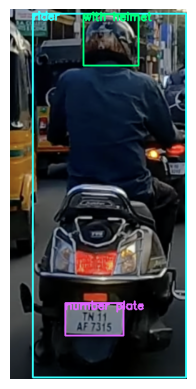

Plotting new10


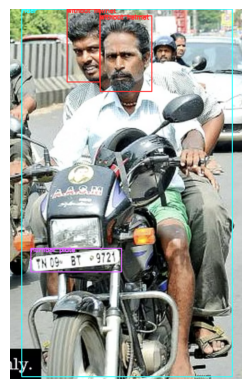

Plotting new100


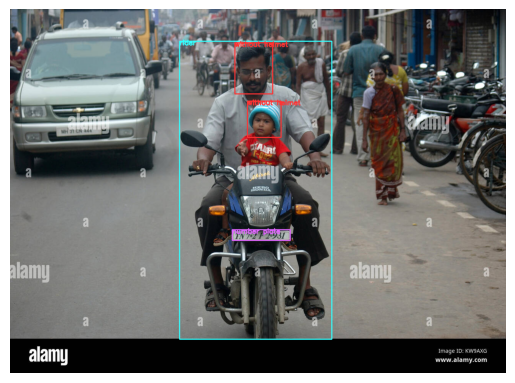

In [ ]:
import os
import cv2
from matplotlib import pyplot as plt

# Update the main path to your dataset
main_path = r'C:\Users\Pc\Downloads\helmet dataset'

# Define id2class_map based on your data.yaml
id2class_map = {
    '0': 'with helmet',
    '1': 'without helmet',
    '2': 'rider',
    '3': 'number plate'  # Matches data.yaml
}

# Define class2color_map with corrected key for 'number plate'
class2color_map = {
    'with helmet': (0, 255, 128),
    'without helmet': (255, 51, 51),
    'rider': (51, 255, 255),
    'number plate': (224, 102, 255)  # Changed from 'number_plate' to 'number plate'
}

def get_bbox_and_label(image_name, data_type='train', main_path=main_path):
    '''Get bounding box and label information from label txt files'''
    lbl_path = os.path.join(main_path, data_type, 'labels', f'{image_name}.txt')
    if not os.path.exists(lbl_path):
        print(f"Label file not found: {lbl_path}")
        return [], []
    with open(lbl_path, 'r') as f:
        lines = f.readlines()
    bboxes = [[float(n) for n in line.split()[1:]] for line in lines]
    labels = [id2class_map[line.split()[0]] for line in lines]
    return bboxes, labels

def load_image(image_name, data_type='train', main_path=main_path):
    '''Load image and convert to RGB'''
    img_path = os.path.join(main_path, data_type, 'images', f'{image_name}.jpg')
    if not os.path.exists(img_path):
        print(f"Image file not found: {img_path}")
        return None
    image = cv2.imread(img_path)
    if image is None:
        print(f"Failed to load image: {img_path}")
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def get_bbox_coordinates(img, bbox):
    '''Convert YOLO bbox to pixel coordinates'''
    img_height, img_width, _ = img.shape
    x_center, y_center, bbox_width, bbox_height = bbox
    x_center_pixel = x_center * img_width
    y_center_pixel = y_center * img_height
    half_width = bbox_width * img_width / 2
    half_height = bbox_height * img_height / 2
    x_min = int(x_center_pixel - half_width)
    y_min = int(y_center_pixel - half_height)
    x_max = int(x_center_pixel + half_width)
    y_max = int(y_center_pixel + half_height)
    return x_min, y_min, x_max, y_max

def plot_image(image_name, data_type='train', class2color_map=class2color_map):
    '''Plot image with bounding boxes and labels'''
    img = load_image(image_name=image_name, data_type=data_type)
    if img is None:
        return
    bboxes, labels = get_bbox_and_label(image_name=image_name, data_type=data_type)
    for bbox, label in zip(bboxes, labels):
        color = class2color_map[label]
        x_min, y_min, x_max, y_max = get_bbox_coordinates(img, bbox)
        img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
        img = cv2.putText(
            img, label, (x_min, y_min + 10),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.6, color=color, thickness=2
        )
    plt.imshow(img)
    plt.axis('off')  # Hide axes for cleaner visualization
    plt.show()

# Get image names from the training directory
image_names = [f.split('.')[0] for f in os.listdir(os.path.join(main_path, 'train', 'images')) 
               if f.endswith('.jpg') and f not in ['new128.jpg', 'new3.jpg']]  # Exclude corrupt images

# Plot a few training images
def new_func(plot_image, img_name):
    plot_image(img_name, data_type='train')

for img_name in image_names[:3]:  # Limit to first 3 images for testing
    print(f"Plotting {img_name}")
    new_func(plot_image, img_name)

In [13]:
# Prepare data.yaml for YOLO training
train_images = os.path.join(main_path, 'train', 'images')
val_images = os.path.join(main_path, 'val', 'images')

data_yaml = f"""
train: {train_images.replace(os.sep, '/')}
val: {val_images.replace(os.sep, '/')}
nc: 4
names: {list(id2class_map.values())}
"""

data_yaml_path = os.path.join(main_path, 'data.yaml')
with open(data_yaml_path, 'w') as f:
    f.write(data_yaml)

# Load and train YOLOv8 model
model = YOLO('yolov8n.pt')  # Use nano model for faster training
model.train(data=data_yaml_path, epochs=30, imgsz=640, batch=16, name='helmet_numberplate_model')

# Run inference on 5 validation images and save outputs
output_dir = os.path.join(main_path, 'output_images')
os.makedirs(output_dir, exist_ok=True)

val_img_files = [f for f in os.listdir(val_images) if f.endswith(('.jpg', '.png'))][:5]

for img_name in val_img_files:
    img_path = os.path.join(val_images, img_name)
    results = model.predict(img_path, imgsz=640)[0]  # Get first result
    annotated_img = results.plot()  # YOLO's built-in plotting with consistent colors
    
    save_path = os.path.join(output_dir, f"pred_{img_name}")
    cv2.imwrite(save_path, cv2.cvtColor(annotated_img, cv2.COLOR_RGB2BGR))
    print(f"Saved prediction image: {save_path}")

New https://pypi.org/project/ultralytics/8.3.145 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.93  Python-3.12.4 torch-2.6.0+cpu CPU (12th Gen Intel Core(TM) i5-12400F)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=C:\Users\Pc\Downloads\helmet dataset\data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=helmet_numberplate_model3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_m

train: Scanning C:\Users\Pc\Downloads\helmet dataset\train\labels.cache... 102 images, 0 backgrounds, 2 corrupt: 100%|██████████| 104/104 [00:00<?, ?it/s]

train: WARNING  C:\Users\Pc\Downloads\helmet dataset\train\images\new128.jpg: ignoring corrupt image/label: cannot identify image file 'C:\\Users\\Pc\\Downloads\\helmet dataset\\train\\images\\new128.jpg'
train: WARNING  C:\Users\Pc\Downloads\helmet dataset\train\images\new3.jpg: ignoring corrupt image/label: invalid image format GIF. Supported formats are:
images: {'png', 'tif', 'heic', 'jpg', 'pfm', 'dng', 'tiff', 'bmp', 'jpeg', 'webp', 'mpo'}
videos: {'gif', 'ts', 'mpg', 'wmv', 'mov', 'mp4', 'mkv', 'm4v', 'mpeg', 'avi', 'asf', 'webm'}



val: Scanning C:\Users\Pc\Downloads\helmet dataset\val\labels.cache... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]

Plotting labels to c:\Users\Pc\runs\detect\helmet_numberplate_model3\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to c:\Users\Pc\runs\detect\helmet_numberplate_model3
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G      1.103      3.556       1.34         67        640: 100%|██████████| 7/7 [00:29<00:00,  4.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]

                   all         20         73     0.0112      0.361      0.163      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/30         0G     0.8736      2.979      1.147         48        640: 100%|██████████| 7/7 [00:26<00:00,  3.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

                   all         20         73     0.0257      0.405      0.243      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/30         0G     0.8942      1.902      1.145         48        640: 100%|██████████| 7/7 [00:25<00:00,  3.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]

                   all         20         73      0.569      0.239      0.249       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/30         0G     0.9193        1.5      1.158         57        640: 100%|██████████| 7/7 [00:25<00:00,  3.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]

                   all         20         73       0.96      0.228      0.556      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/30         0G     0.8184      1.311      1.071         46        640: 100%|██████████| 7/7 [00:25<00:00,  3.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]

                   all         20         73      0.975      0.228      0.718      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/30         0G     0.8271      1.121      1.048         42        640: 100%|██████████| 7/7 [00:25<00:00,  3.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]

                   all         20         73      0.952      0.228      0.803      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30         0G     0.8139       1.05      1.045         46        640: 100%|██████████| 7/7 [00:25<00:00,  3.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]

                   all         20         73      0.964      0.329       0.78       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/30         0G     0.7883       1.01       1.04         59        640: 100%|██████████| 7/7 [00:26<00:00,  3.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]

                   all         20         73      0.962      0.297      0.776      0.631

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/30         0G     0.7961      1.005      1.055         47        640: 100%|██████████| 7/7 [00:26<00:00,  3.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  2.00s/it]

                   all         20         73      0.894      0.285      0.748      0.613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/30         0G      0.794     0.9764      1.005         64        640: 100%|██████████| 7/7 [00:26<00:00,  3.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]

                   all         20         73      0.916      0.412      0.822      0.639

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/30         0G     0.7895     0.9522      1.062         26        640: 100%|██████████| 7/7 [00:25<00:00,  3.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]

                   all         20         73      0.947      0.494      0.815      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/30         0G     0.7728     0.9392      1.015         51        640: 100%|██████████| 7/7 [00:26<00:00,  3.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]

                   all         20         73        0.9      0.474      0.852      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/30         0G     0.7431     0.8818      1.029         39        640: 100%|██████████| 7/7 [00:25<00:00,  3.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]

                   all         20         73      0.906      0.549      0.859       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/30         0G     0.7469     0.8608      1.018         32        640: 100%|██████████| 7/7 [00:25<00:00,  3.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]

                   all         20         73      0.881      0.681      0.898      0.689

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/30         0G     0.7473     0.8291      1.029         44        640: 100%|██████████| 7/7 [00:25<00:00,  3.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

                   all         20         73      0.857      0.808      0.909      0.739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/30         0G     0.6954     0.7917     0.9991         37        640: 100%|██████████| 7/7 [00:25<00:00,  3.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]

                   all         20         73      0.871      0.843      0.917      0.751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/30         0G     0.6356     0.7472     0.9619         44        640: 100%|██████████| 7/7 [00:25<00:00,  3.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]

                   all         20         73      0.838      0.851      0.924      0.748

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/30         0G      0.725     0.8115      1.015         41        640: 100%|██████████| 7/7 [00:25<00:00,  3.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]

                   all         20         73      0.876      0.897      0.938       0.76

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/30         0G     0.7152     0.8016     0.9934         35        640: 100%|██████████| 7/7 [00:25<00:00,  3.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  2.00s/it]

                   all         20         73      0.887      0.907      0.946      0.775

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/30         0G     0.6955     0.7709     0.9849         36        640: 100%|██████████| 7/7 [00:25<00:00,  3.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]

                   all         20         73       0.88      0.918      0.954      0.772
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/30         0G     0.6727      1.006     0.9596         31        640: 100%|██████████| 7/7 [00:25<00:00,  3.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

                   all         20         73      0.901      0.922      0.964      0.784

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/30         0G      0.616       0.92     0.9428         21        640: 100%|██████████| 7/7 [00:24<00:00,  3.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]

                   all         20         73      0.932       0.87      0.951      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/30         0G     0.6112     0.9023     0.9355         21        640: 100%|██████████| 7/7 [00:24<00:00,  3.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]

                   all         20         73      0.916      0.856      0.956      0.784

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/30         0G     0.6182     0.8621     0.9398         20        640: 100%|██████████| 7/7 [00:25<00:00,  3.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  2.00s/it]

                   all         20         73      0.894      0.929      0.965      0.802

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/30         0G     0.6081     0.8143     0.9289         26        640: 100%|██████████| 7/7 [00:24<00:00,  3.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]

                   all         20         73      0.899      0.919      0.958      0.806

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      26/30         0G     0.5557     0.7812     0.9062         19        640: 100%|██████████| 7/7 [00:25<00:00,  3.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]

                   all         20         73      0.912       0.91      0.956      0.813

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      27/30         0G     0.5857     0.7887     0.9064         19        640: 100%|██████████| 7/7 [00:25<00:00,  3.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]

                   all         20         73      0.905      0.908      0.958      0.808

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      28/30         0G       0.56     0.7642     0.9134         19        640: 100%|██████████| 7/7 [00:25<00:00,  3.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]

                   all         20         73      0.904      0.903      0.955      0.812

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      29/30         0G     0.5706      0.787     0.9151         28        640: 100%|██████████| 7/7 [00:25<00:00,  3.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]

                   all         20         73      0.886      0.918      0.956      0.813

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      30/30         0G     0.5427     0.7631     0.8898         24        640: 100%|██████████| 7/7 [00:24<00:00,  3.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]

                   all         20         73      0.898      0.929      0.956      0.813

30 epochs completed in 0.233 hours.


Optimizer stripped from c:\Users\Pc\runs\detect\helmet_numberplate_model3\weights\last.pt, 6.2MB
Optimizer stripped from c:\Users\Pc\runs\detect\helmet_numberplate_model3\weights\best.pt, 6.2MB

Validating c:\Users\Pc\runs\detect\helmet_numberplate_model3\weights\best.pt...
Ultralytics 8.3.93  Python-3.12.4 torch-2.6.0+cpu CPU (12th Gen Intel Core(TM) i5-12400F)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


                   all         20         73      0.885      0.918      0.955      0.813
           with helmet         12         13      0.983      0.923      0.961      0.827
        without helmet         10         15      0.769      0.891      0.914      0.727
                 rider         20         23      0.835      0.913      0.971      0.878
          number plate         20         22      0.954      0.945      0.974      0.819
Speed: 1.7ms preprocess, 66.1ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to c:\Users\Pc\runs\detect\helmet_numberplate_model3

image 1/1 C:\Users\Pc\Downloads\helmet dataset\val\images\new0.jpg: 640x576 2 without helmets, 1 rider, 1 number plate, 48.9ms
Speed: 2.9ms preprocess, 48.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Saved prediction image: C:\Users\Pc\Downloads\helmet dataset\output_images\pred_new0.jpg

image 1/1 C:\Users\Pc\Downloads\helmet dataset\val\images\new113.jpg: 640x576 2 with helme

In [15]:
# Validate the model on the validation set
results = model.val(data=data_yaml_path)
print("Validation Results Summary:")
print(results)  # Print a summary of the validation metrics
print("\nBox Metrics:", results.box)
print("Speed:", results.speed)

# Optional: Run inference on 5 validation images and save outputs
output_dir = os.path.join(main_path, 'output_images')
os.makedirs(output_dir, exist_ok=True)

val_img_files = [f for f in os.listdir(val_images) if f.endswith(('.jpg', '.png'))][:5]

for img_name in val_img_files:
    img_path = os.path.join(val_images, img_name)
    results = model.predict(img_path, imgsz=640)[0]  # Get first result
    annotated_img = results.plot()  # YOLO's built-in plotting with consistent colors
    
    save_path = os.path.join(output_dir, f"pred_{img_name}")
    cv2.imwrite(save_path, cv2.cvtColor(annotated_img, cv2.COLOR_RGB2BGR))
    print(f"Saved prediction image: {save_path}")

Ultralytics 8.3.93  Python-3.12.4 torch-2.6.0+cpu CPU (12th Gen Intel Core(TM) i5-12400F)


val: Scanning C:\Users\Pc\Downloads\helmet dataset\val\labels.cache... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


                   all         20         73      0.891      0.936      0.962       0.81
           with helmet         12         13      0.969      0.923      0.963      0.818
        without helmet         10         15      0.763      0.933      0.927      0.725
                 rider         20         23      0.878      0.939      0.983      0.873
          number plate         20         22      0.954      0.949      0.974      0.824
Speed: 4.4ms preprocess, 60.2ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to c:\Users\Pc\runs\detect\helmet_numberplate_model32
Validation Results Summary:
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001DBC6297050>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,  

In [23]:
from matplotlib import pyplot as plt

# Run inference on validation images (up to 5), save and display outputs in popup windows
for img_name in val_img_files:
    img_path = os.path.join(val_images, img_name)
    results = model.predict(img_path, imgsz=640)[0]
    annotated_img = results.plot()
    save_path = os.path.join(output_dir, f"pred_val_{img_name}")
    cv2.imwrite(save_path, cv2.cvtColor(annotated_img, cv2.COLOR_RGB2BGR))
    print(f"Saved validation prediction image: {save_path}")
    # Show image in a popup window
    cv2.imshow(f"Prediction: {img_name}", cv2.cvtColor(annotated_img, cv2.COLOR_RGB2BGR))
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Run inference on custom test images, save and display outputs in popup windows
for img_path in test_images:
    if not os.path.exists(img_path):
        print(f"Test image not found: {img_path}")
        continue
    results = model.predict(img_path, imgsz=640)[0]
    annotated_img = results.plot()
    output_path = os.path.join(output_dir, f"pred_test_{os.path.basename(img_path)}")
    cv2.imwrite(output_path, cv2.cvtColor(annotated_img, cv2.COLOR_RGB2BGR))
    print(f"Saved test prediction image: {output_path}")
    # Show image in a popup window
    cv2.imshow(f"Prediction: {os.path.basename(img_path)}", cv2.cvtColor(annotated_img, cv2.COLOR_RGB2BGR))
    cv2.waitKey(0)
    cv2.destroyAllWindows()



image 1/1 C:\Users\Pc\Downloads\helmet dataset\val\images\new0.jpg: 640x576 2 without helmets, 1 rider, 1 number plate, 58.0ms
Speed: 4.1ms preprocess, 58.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)
Saved validation prediction image: C:\Users\Pc\Downloads\helmet dataset\output_images\pred_val_new0.jpg

image 1/1 C:\Users\Pc\Downloads\helmet dataset\val\images\new113.jpg: 640x576 2 with helmets, 1 rider, 1 number plate, 48.9ms
Speed: 3.9ms preprocess, 48.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
Saved validation prediction image: C:\Users\Pc\Downloads\helmet dataset\output_images\pred_val_new113.jpg

image 1/1 C:\Users\Pc\Downloads\helmet dataset\val\images\new115.jpg: 576x640 1 with helmet, 1 rider, 1 number plate, 53.8ms
Speed: 2.8ms preprocess, 53.8ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)
Saved validation prediction image: C:\Users\Pc\Downloads\helmet dataset\output_images\pred_val_new115.jpg

image 1/1 C